In [1]:
import os
import gc
import glob
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import climpred
from climpred import HindcastEnsemble
from functools import partial
import xarray as xr
from eofs.xarray import Eof
import xesmf as xe
import xskillscore as xs
import readnc_tools as rd
import readnc2_tools as rd2
import plot_tools as pt

path_temp="/cnrm/pastel/DATA/REF/era5/ncdf/daily/"
path_snow="/cnrm/pastel/USERS/ardilouzec/obs/era5_land/"
lat_lims = [30,90]

<frozen importlib._bootstrap>:219: UserWarning: PROJ 8+ is required. Current version: 7.2.0


In [3]:
#Loading daily ERA5 T2M from 1993 to 2018
ref='era5'
variables=['t2m','z500']
#min_lat=40 ; max_lat=53; min_lon=110; max_lon=140 #China/Russia
min_lat=39 ; max_lat=50; min_lon=255; max_lon=290  #NAmerica
temp0=rd.read_ref(path_temp,variables,ref)
#Compute daily anomalies
temp0=(temp0.groupby("time.dayofyear")-temp0.groupby("time.dayofyear").mean("time")).sel(lat=slice(30,78),lon=slice(0,360)).compute()
# select the grid points inside the red box (North China/South-East Russia) and perform spatial averaging
temp=temp0.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon)).mean(["lat","lon"]).compute()

In [4]:
#Loading daily ERA5Land Snow depth Water equivalent from 1993 to 2018 (February to May only)
ref='era5land'
variables=['sd']
sn=rd.read_ref(path_snow,variables,ref)
sn=sn.groupby("time.dayofyear")-sn.groupby("time.dayofyear").mean("time")

In [5]:
#Artificially complete the Snow time series to match the temperature time series (filling with NAs)
sn=sn.reindex({"time":temp.time}).compute()

In [6]:
#Rename sd to snow to avoid a confusion between sd (=snow depth) and std (standard deviation) 
sn=sn.rename({'sd':'snow'})

Text(0.5, 1.0, 'Standard deviation of Feb-to-May ERA5-Land snow cover anomalies (snow depth water equivalent)')

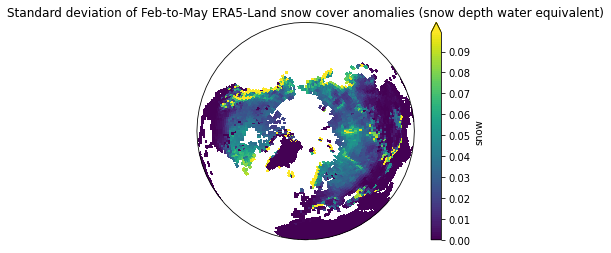

In [7]:
#quick look at the snow depth standard deviation over the entire Feb-To-May 1993-to-2018 period. Not very informative
sn.snow.std(dim='time').sel(lat=slice(0,90)).plot(levels=[np.round(x,3) for x in np.arange(0,0.1,0.001)],transform=ccrs.PlateCarree(),subplot_kws=dict(projection=ccrs.Orthographic(central_longitude=0, central_latitude=90))
                                            )
plt.title("Standard deviation of Feb-to-May ERA5-Land snow cover anomalies (snow depth water equivalent)")

Text(0.5, 1.0, 'PC2 Variance fraction=0.12')

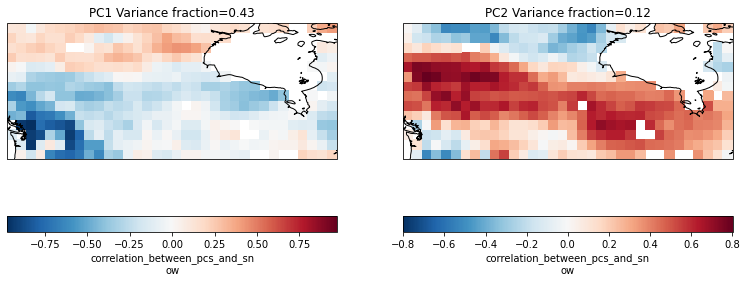

In [23]:
#Extract Snow depth time comprised between 17 Feb and 18 March (representative of early spring initialization)
snmonth=sn.where(((sn.time.dt.month==2)&(sn.time.dt.day>=17))|((sn.time.dt.month==3)&(sn.time.dt.day<=18))).dropna(dim='time',how='all')
#Extract Eurasian domain, compute EOFs and plot the first EOF with fraction of explained variance
sneof=snmonth.snow.sel(lat=slice(45,78),lon=slice(25,150)) 
sneof=snmonth.snow.sel(lat=slice(45,65),lon=slice(235,285))
coslat = np.cos(np.deg2rad(sneof.coords['lat'].values)).clip(0., 1.)
wgts = np.sqrt(coslat)[..., np.newaxis]
solver=Eof(sneof,weights=wgts)
eofs=solver.eofsAsCorrelation(neofs=3)
expl_var=solver.varianceFraction(neigs=3)
fig,axs = plt.subplots(ncols=2,figsize=(13, 7),subplot_kw=dict(projection=ccrs.PlateCarree()))
p=eofs[0].plot(ax=axs[0],transform=ccrs.PlateCarree(),cbar_kwargs={"orientation":"horizontal"})
p.axes.coastlines()
p=eofs[1].plot(ax=axs[1],transform=ccrs.PlateCarree(),cbar_kwargs={"orientation":"horizontal"})
#pcs=solver.pcs(npcs=3)
p.axes.coastlines()
axs[0].set_title('PC1 Variance fraction='+str(np.round(expl_var[0].values,2)))
axs[1].set_title('PC2 Variance fraction='+str(np.round(expl_var[1].values,2)))

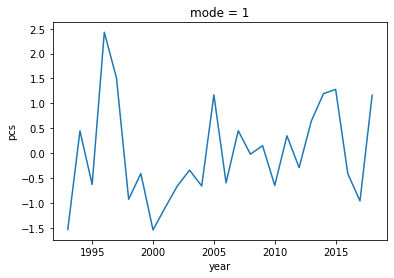

In [9]:
#daily Principal components scaled to unit variance 
pc1=solver.pcs(npcs=3, pcscaling=1)
#trick to better represent time axix in plot
a=xr.DataArray(pc1[:,1],dims=['time'])
#Yearly averaging the time series associated to PC1 and plotting:
a.groupby('time.year').mean('time').plot()

In [10]:
# we compute 7-day and 30-day rolling mean for temperature (weekly anomalies) but nor for snow (to comply with subseasonal forecast context)
#snow=sn.rolling(time=7).mean().dropna(dim='time',how='all')
temp1=temp.rolling(time=30).mean().dropna(dim='time')
temp2=temp.rolling(time=7).mean().dropna(dim='time')
print(temp1.time)

<xarray.DataArray 'time' (time: 9467)>
array(['1993-01-30T00:00:00.000000000', '1993-01-31T00:00:00.000000000',
       '1993-02-01T00:00:00.000000000', ..., '2018-12-29T00:00:00.000000000',
       '2018-12-30T00:00:00.000000000', '2018-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time       (time) datetime64[ns] 1993-01-30 1993-01-31 ... 2018-12-31
    dayofyear  (time) int64 30 31 32 33 34 35 36 ... 359 360 361 362 363 364 365


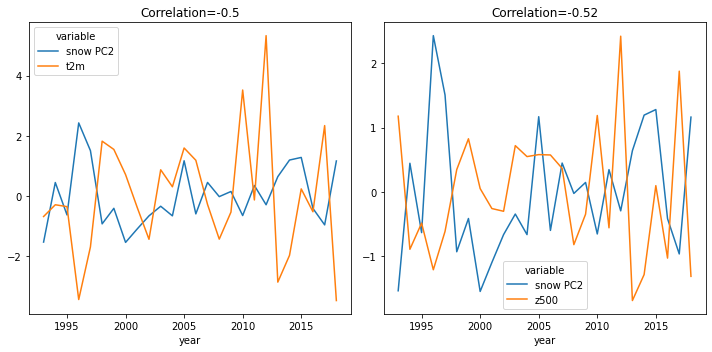

In [25]:
#we select 30-day rolling mean temperature time series at 15 Aprils (= averaged over the 30 day period 18 March-15-April) 
temp1=temp1.where((temp1.time.dt.month==4)&(temp1.time.dt.day==15))
#we correlate yearly averages of the Principal component time series of EOF1 and the temperature index
c=xr.corr(temp1.groupby('time.year').mean('time').t2m,a.groupby('time.year').mean('time'))
c2=xr.corr(temp1.groupby('time.year').mean('time').z500,a.groupby('time.year').mean('time'))
fig,axs = plt.subplots(ncols=2,figsize=(10, 5))
t=xr.combine_by_coords([temp1.groupby('time.year').mean('time').t2m,a.groupby('time.year').mean('time')])
t.rename({'pcs':'snow PC2'}).to_array().plot.line(ax=axs[0],x='year')
axs[0].set_title("Correlation="+str(np.round(c.values,2)))
#Normalization to unit variance for z500 time series
ts=(temp1.groupby('time.year').mean('time').z500 - temp1.groupby('time.year').mean('time').z500.mean('year'))/temp1.groupby('time.year').mean('time').z500.std('year')
t=xr.combine_by_coords([ts,a.groupby('time.year').mean('time')])
t.rename({'pcs':'snow PC2'}).to_array().plot.line(ax=axs[1],x='year')
axs[1].set_title("Correlation="+str(np.round(c2.values,2)))
fig.tight_layout()
plt.show()

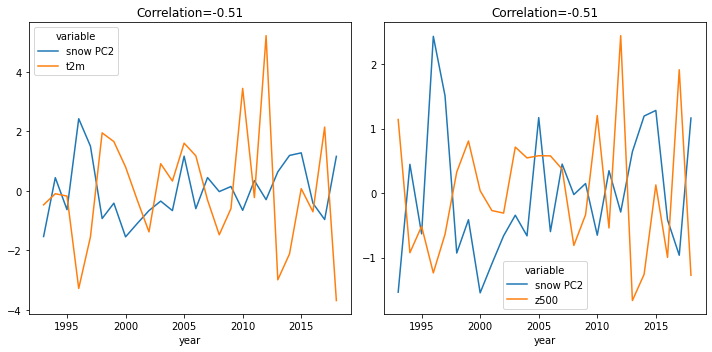

In [26]:
#Same as above but after linearly detrending temperature time series
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit
detrended_temp=detrend_dim(da=temp1.groupby('time.year').mean('time').t2m,dim='year').rename('t2m')
detrended_z=detrend_dim(da=ts,dim='year').rename('z500')
#we correlate yearly averages of the Principal component time series of EOF1 and the temperature index
c=xr.corr(detrended_temp,a.groupby('time.year').mean('time'))
c2=xr.corr(detrended_z,a.groupby('time.year').mean('time'))
fig,axs = plt.subplots(ncols=2,figsize=(10, 5))
t=xr.combine_by_coords([detrended_temp,a.groupby('time.year').mean('time')])
t.rename({'pcs':'snow PC2'}).to_array().plot.line(ax=axs[0],x='year')
axs[0].set_title("Correlation="+str(np.round(c.values,2)))
t=xr.combine_by_coords([detrended_z,a.groupby('time.year').mean('time')])
t.rename({'pcs':'snow PC2'}).to_array().plot.line(ax=axs[1],x='year')
axs[1].set_title("Correlation="+str(np.round(c2.values,2)))
fig.tight_layout()

/home/ardilouzec/miniconda3/envs/climpred/lib/python3.8/site-packages/xskillscore/core/deterministic.py:462: UserWarning: ['year'] is not 'time'. Make sure that you are applying this over a temporal dimension.
  warnings.warn(


Text(0.5, 1.0, 'Correlation of average 18 March-15 April z500 anomaly (ERA5) with PC2 of 17 Feb- 18 March snow depth water equivalent (ERA5-Land)')

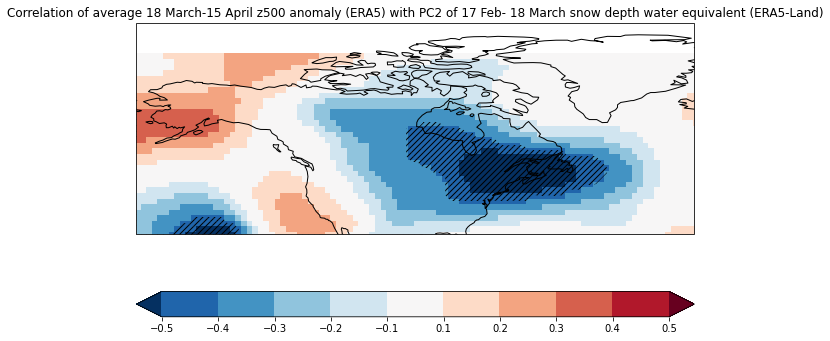

In [24]:
#Plot the correlation and hatch significant values at the 0.05% confidence level
#between PC1 of 17 Feb to 18 March Eurasian snow and 18March to 15April grid point z500 
zmonth=temp0.where(((temp0.time.dt.month==3)&(temp0.time.dt.day>=18))|((temp0.time.dt.month==4)&(temp0.time.dt.day<=15))).dropna(dim='time',how='all')
levels = [np.round(x,2) for x in np.arange(-0.5,0.6,0.1) ]
levels.remove(0)
fig = plt.figure(figsize=(10, 7))
p=xs.pearson_r(zmonth.z500.groupby('time.year').mean('time'),a.groupby('time.year').mean('time'),dim='year').sel(lat=slice(0,80)).plot(x='lon',y='lat',levels=levels,extend='both',transform=ccrs.PlateCarree(),subplot_kws=dict(projection=ccrs.PlateCarree()),cbar_kwargs={"orientation":"horizontal"})
s=xs.pearson_r_eff_p_value(zmonth.z500.groupby('time.year').mean('time'),a.groupby('time.year').mean('time'),dim='year').sel(lat=slice(0,80))
s=s.where(s<=0.05)
s.plot.contourf('lon','lat',ax=p.axes,colors='None',add_colorbar=False,hatches=[4*'/'],transform=ccrs.PlateCarree(),alpha=0)
#pt.polarCentral_set_latlim(lat_lims,p.axes)
p.axes.coastlines()
p.axes.set_extent([190,340,30,78])
#p.axes.add_patch(mpatches.Rectangle(zorder=2,xy=[110, 40], width=30, height=13, facecolor='none',edgecolor='red',linewidth=2,transform=ccrs.PlateCarree()))
#p.axes.add_patch(mpatches.Rectangle(zorder=2,xy=[255, 39], width=35, height=11, facecolor='none',edgecolor='red',linewidth=2,transform=ccrs.PlateCarree()))
plt.title("Correlation of average 18 March-15 April z500 anomaly (ERA5) with PC2 of 17 Feb- 18 March snow depth water equivalent (ERA5-Land)")

In [ ]:
#Plot the pearson correlation and hatch significant values at the 0.05% confidence level
#between yearly averages of 17 Feb to 18 March snow and 18March to 15April Red box 2m Temperature 
levels = [np.round(x,2) for x in np.arange(-0.5,0.6,0.1) ]
levels.remove(0)
fig = plt.figure(figsize=(10, 7))
p=xs.pearson_r(snmonth.snow.groupby('time.year').mean('time'),detrended_temp,dim='year').sel(lat=slice(0,80)).plot(x='lon',y='lat',levels=levels,extend='both',transform=ccrs.PlateCarree(),subplot_kws=dict(projection=ccrs.NorthPolarStereo()))
s=xs.pearson_r_eff_p_value(snmonth.snow.groupby('time.year').mean('time'),detrended_temp,dim='year').sel(lat=slice(0,80))
s=s.where(s<=0.05)
s.plot.contourf('lon','lat',ax=p.axes,colors='None',add_colorbar=False,hatches=[4*'/'],transform=ccrs.PlateCarree(),alpha=0)
pt.polarCentral_set_latlim(lat_lims,p.axes)
p.axes.coastlines()
#p.axes.add_patch(mpatches.Rectangle(zorder=2,xy=[110, 40], width=30, height=13, facecolor='none',edgecolor='red',linewidth=2,transform=ccrs.PlateCarree()))
p.axes.add_patch(mpatches.Rectangle(zorder=2,xy=[255, 39], width=35, height=11, facecolor='none',edgecolor='red',linewidth=2,transform=ccrs.PlateCarree()))
plt.title("Correlation of average 18 March-15 April 2m temperature anomaly (ERA5) averaged over the red box with average 17 Feb- 18 March snow depth water equivalent (ERA5-Land)")

/home/ardilouzec/miniconda3/envs/climpred/lib/python3.8/site-packages/xskillscore/core/deterministic.py:462: UserWarning: ['year'] is not 'time'. Make sure that you are applying this over a temporal dimension.
  warnings.warn(


In [19]:
# Same idea as bove, but mimicking subseasonal forecasting
#We keep only the 25 Feb, 4 March, 11 March and 18 March for snow depth water equivalent anomalies
sn=sn.where(((sn.time.dt.month==2) & (sn.time.dt.day==25)) | ((sn.time.dt.month==3) & (np.isin(sn.time.dt.day,[4,11,18])))).dropna(dim='time',how='all')
#We keep for each year the 4 corresponding 7-day rolling mean temperature 25 days after the snow dates
test_temp=temp2.shift(time=-25).reindex({'time':sn.time}) #Reminder: temp2 = 7-day rolling mean temperature. 

In [16]:
#Plot the pearson correlation and hatch significant values at the 0.05% confidence level
levels = [np.round(x,2) for x in np.arange(-0.5,0.6,0.1) ]
levels.remove(0)
p=xs.pearson_r(sn.snow,test_temp.t2m,dim='time').sel(lat=slice(0,80)).plot(x='lon',y='lat',levels=levels,extend='both',transform=ccrs.PlateCarree(),subplot_kws=dict(projection=ccrs.NorthPolarStereo()))
s=xs.pearson_r_eff_p_value(sn.snow,test_temp.t2m,dim='time').sel(lat=slice(0,80))
s=s.where(s<=0.05)
s.plot.contourf('lon','lat',ax=p.axes,colors='None',add_colorbar=False,hatches=[4*'/'],transform=ccrs.PlateCarree(),alpha=0)
pt.polarCentral_set_latlim(lat_lims,p.axes)
p.axes.coastlines()
#p.axes.add_patch(mpatches.Rectangle(zorder=2,xy=[110, 40], width=30, height=13, facecolor='none',edgecolor='red',linewidth=2,transform=ccrs.PlateCarree()))
p.axes.add_patch(mpatches.Rectangle(zorder=2,xy=[250, 37], width=40, height=13, facecolor='none',edgecolor='red',linewidth=2,transform=ccrs.PlateCarree()))
plt.title("Correlation of 'week 4' 2m temperature anomaly (ERA5) averaged over the red box with initial snow depth water equivalent (ERA5-Land)")

NameError: name 'test_temp' is not defined

Text(0.5, 1.0, 'Mean snow evolution btwn 25 Feb.and 18 March')

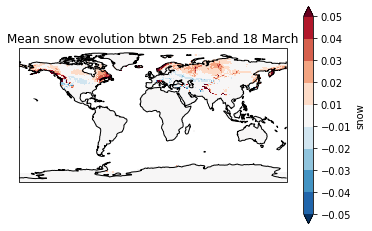

In [21]:
#Not very informative plot: Mean snow depth evolution btwn 25 Feb.and 18 March
ref='era5land'
variables=['sd']
snfull=rd.read_ref(path_snow,variables,ref).compute()
snfull=snfull.rename({'sd':'snow'})

levels = [np.round(x,2) for x in np.arange(-0.05,0.06,0.01) ]
levels.remove(0)
g=snfull.where((snfull.time.dt.month==3) & (snfull.time.dt.day==18)).dropna(dim='time',how='all')
f=snfull.where((snfull.time.dt.month==2) & (snfull.time.dt.day==25)).dropna(dim='time',how='all')
#a.sd.mean('time').plot(levels=[np.round(x,2) for x in np.arange(0,0.55,0.05)])
p=(g.snow.mean('time')-f.snow.mean('time')).plot(levels=levels,transform=ccrs.PlateCarree(),subplot_kws=dict(projection=ccrs.PlateCarree()))
p.axes.coastlines()
plt.title("Mean snow evolution btwn 25 Feb.and 18 March")